# Semantic Segmentation of Water using U-Net
# Part 8 - Hyperparameter Tuning

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
import time
from itertools import product

from unetlib.metrics import BinaryMeanIoU
from unetlib.model import UNet_BN
import unetlib.visualisation as vs
from unetlib.pipelines import train_unet

In [2]:
# Imagery directories
nwpu_data_dir = 'nwpu_lake_images/data/'
nwpu_mask_dir = 'nwpu_lake_images/masks/'

## Epochs

Up to this point I have hard coded the number of epochs for each training process. This has allowed me to investigate models without consuming too much time/compute resources. However, I really want to make sure that the models are allowed to train until convergence. Rather than experiment with a variety of epoch numbers I can implement early stopping based on the loss; this means training will stop when it is no longer improving.

Stopping conditions can be implemented using a the `EarlyStopping` callback from Keras. By default the callback will monitor `val_loss` and stop training when this increases. However, as can be seen from the previous plots of training history, the loss curves can be rather noisey. Stopping after the first sign of an increase in loss is too strict in this case and so I can add a `patience` value to specify how many epochs of no loss improvement I want to wait before halting training.

In [4]:
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
# Stop if no improvement for 50 epochs.
early_stop = EarlyStopping(patience=50)

With only this change let's see how many epochs the best model from Part 7 runs for. I'm also creating a custom callback that will record the total training time.

In [6]:
class TrainingTimer(tf.keras.callbacks.Callback):
    """Times the model's training process.
    """
    def __init__(self):
        self.logs = {}
    def on_train_begin(self, logs=None):
        # Record start time
        self.logs['start_time'] = time.time()

    def on_train_end(self, logs=None):
        # Record stop time
        self.logs['stop_time'] = time.time()
        # Calculate and record runtime
        self.logs['runtime'] = self.logs['stop_time'] - self.logs['start_time']
        
    def runtime_seconds(self):
        return self.logs.get('runtime', 0.)
    
    def runtime_minutes(self):
        return self.runtime_seconds() / 60
    
    def runtime_hours(self):
        return self.runtime_seconds() / 3600

In [13]:
## Configure other callbacks
# Checkpointer
checkpointer = tf.keras.callbacks.ModelCheckpoint(f"model_outputs/{model.name}.weights.h5",
                                                  save_best_only=True,
                                                  save_weights_only=True
                                                  )

# Timer
timer = TrainingTimer()

In [4]:
# Train model with early stopping
# model = UNet_BN(n_filters=64, n_blocks=4, bn_pos='before', model_name='deepwide_earlystop')
# es_hist_filepath = train_unet(model, nwpu_data_dir, nwpu_mask_dir,
#                               epochs=500, # Set a maximum in case early stopping isn't triggered
#                               callbacks=callbacks=[early_stop, checkpointer, timer],
#                               save_dir='model_outputs')

# Or use pre-trained model
es_hist_filepath = 'model_outputs/deepwide_earlystop_f64_b4_bnbefore.history.pickle'

In [ ]:
# If model has been trained in this session, callbacks can be accessed
print('Runtime: ', timer.runtime_minutes())
print('Best epoch: ', early_stop.stopped_epoch - early_stop.patience)
print('Best val_loss ', checkpointer.best)

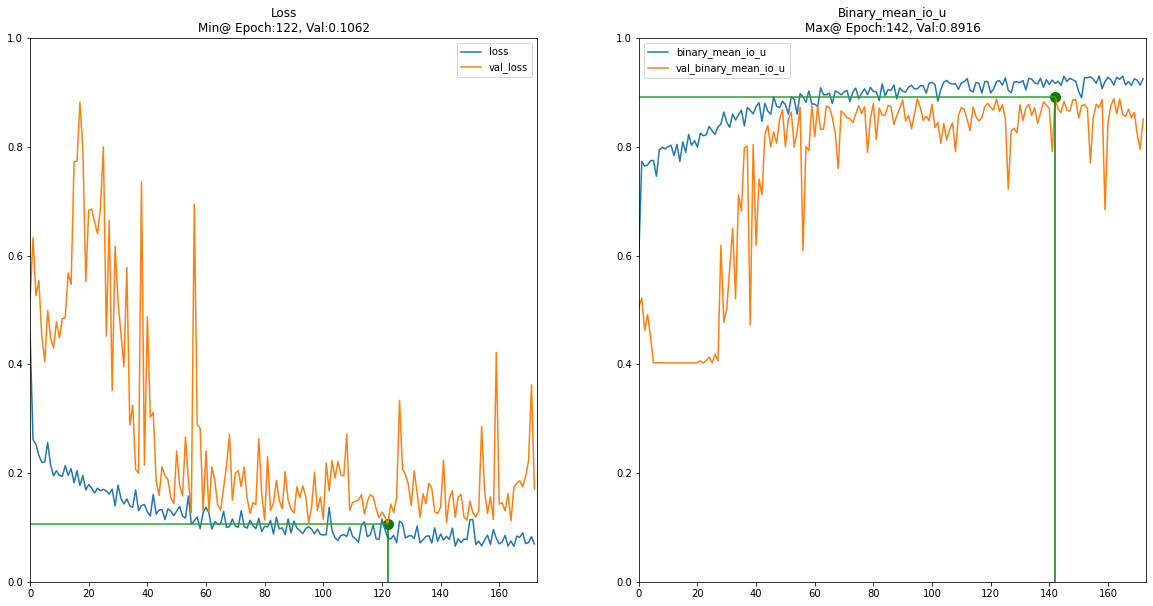

In [7]:
# Review learnining curves
with open(es_hist_filepath, 'rb') as f:
    es_hist = pickle.load(f)
es_hist_df = pd.DataFrame(es_hist)

vs.plot_model_history(es_hist_df, metrics=['loss', 'binary_mean_io_u'], best=['min','max']);

In [8]:
best_epoch = es_hist_df.val_loss.argmin()
iou_at_epoch = es_hist_df.at[best_epoch, 'val_binary_mean_io_u']

print('Best epoch: ', best_epoch)
print('Best val_loss ', es_hist_df.val_loss.min())
print(f'Mean IoU at epoch {best_epoch}:', iou_at_epoch )

Best epoch:  122
Best val_loss  0.10617024451494217
Mean IoU at epoch 122: 0.887973427772522


The model now trains for more epochs than previously and reaches a better `val_loss` value. The `val_binary_mean_io_u` value has also improved slighly; epoch 142 reached the best value but training stops according to the best `val_loss` at epoch 122. At this epoch the `val_binary_mean_io_u` also shows an improvement on model trained without early stopping.

Note that the improvements are small and could also be due to the random initialisation of the weights. To get a more robust assessment it is best practice to train the model several times to derive the mean and standard deviation of the metrics. This can be achieved through cross-validation or by repeating the training process above and keeping a record of the results.

## Optimiser and Learning Rate

The choice of optimser and learning rate can have a huge impact on model training and convergence. Mostly, packages use reasonable defaults but time should be spent on tuning these parameters.

Typically, the model should be trained using a selection of learning rates and whichever yields the best validation loss should be kept. It is not practical or efficient to test every possible value so a common strategy in the literature is to test powers of 10 e.g. 0.001, 0.01, 0.1 etc.

Another common approach is to allow the learning rate to be decreased during the training process. This means that earlier steps can make larger movements but as the model converges, the learning rate gets smaller so small steps can me made to avoid overshooting the minimum. One way of implementing this is to use a learning rate scheduler to reduce the rate after a certain number of epochs, though it can be difficult to determine at which epochs the rate should be reudced. An alternative is to reduce the learning rate whenever the loss doesnt improve for a certain amount of time.

There are also many choices of optimisers charicterised by their approach to gradient descent. Some make use of momentum (i.e. the gradient history), looking ahead before descending and direction correction. RMSProp is very widely used in the literature and should be a good optimiser to start with. Similarly the Adam optimiser is widely used. Both of these are adaptive techniques which allow for less tuning of the learning rate.

Here I will run some experiments with the choice of optimiser and learning rates.

In [ ]:
# Train models
optimisers = ['RMSProp', 'Adam']
learning_rates = [0.001, 0.01, 0.1, 1]
histories = []

for opt, lr in product(optimisers, learning_rates):
    # Create model
    model = UNet_BN(n_filters=64, n_blocks=4, bn_pos='before', model_name='deepwide')
    
    # Generate output base filename including optimiser and learning rate
    base_fn = f"{model.name}_{opt}_lr{lr:.3f}"
    
    ## Configure callbacks
    # Checkpointer
    checkpointer = tf.keras.callbacks.ModelCheckpoint(f'model_outputs/{base_fn}.weights.h5',
                                                      save_best_only=True,
                                                      save_weights_only=True
                                                      )
    
    # Early stopping
    early_stop = EarlyStopping(patience=50)
    
    # Train model
    history = train_unet(model, nwpu_data_dir, nwpu_mask_dir, epochs=500,
                         optimiser=opt, learning_rate=lr
                         callbacks=[early_stop, checkpointer],
                         save_as=base_fn,
                         save_dir='model_outputs')
    
    histories.append(history)

In [28]:
# Or use pre-trained model
out_dir = 'model_outputs'
ptn = r'deepwide_f64_b4_bnbefore_(?:RMSprop|Adam)_lr\d\.\d{3}\.history.pickle'
histories = [os.path.join(out_dir, fn) for fn in 
             list(filter(lambda x: re.match(ptn,x),os.listdir(out_dir)))]

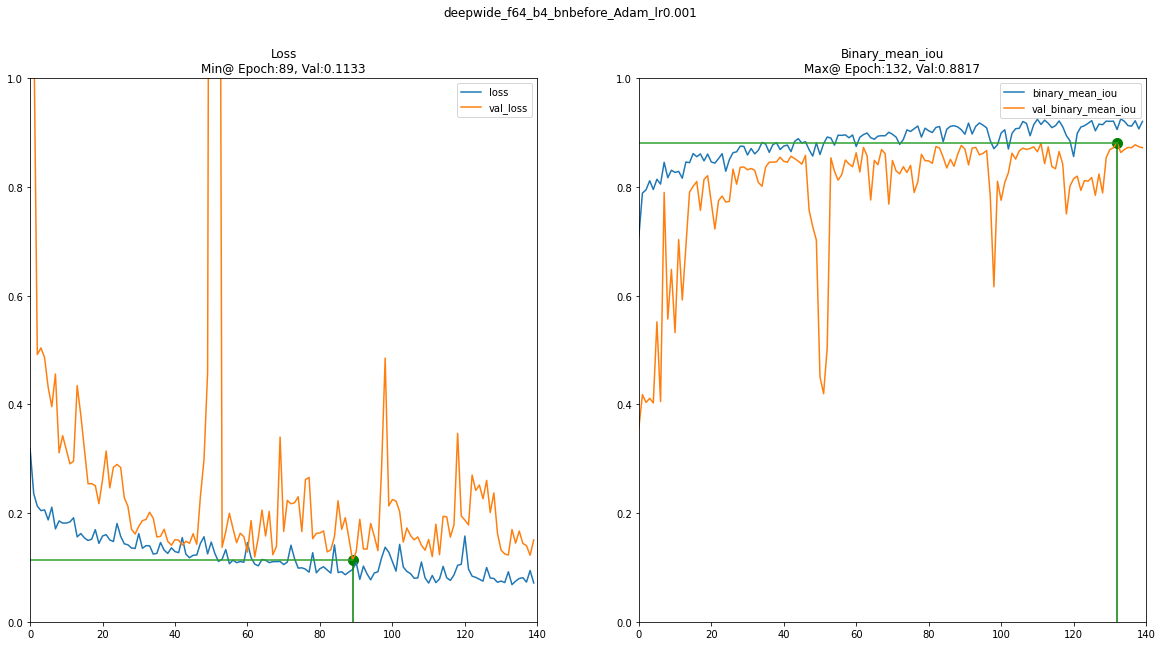

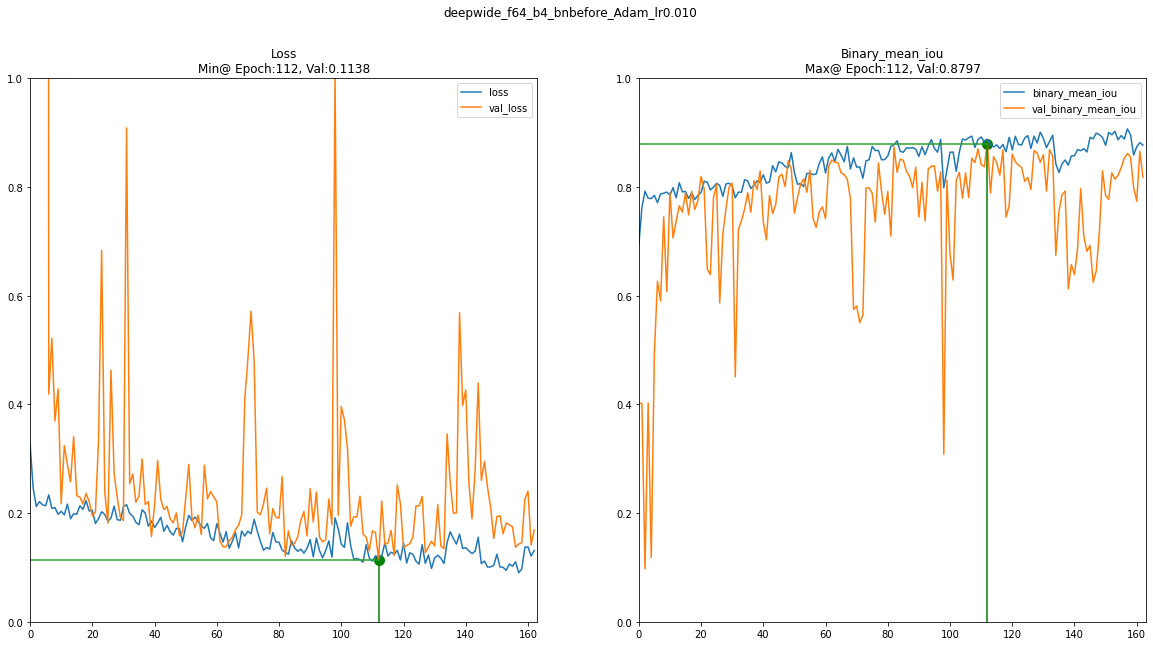

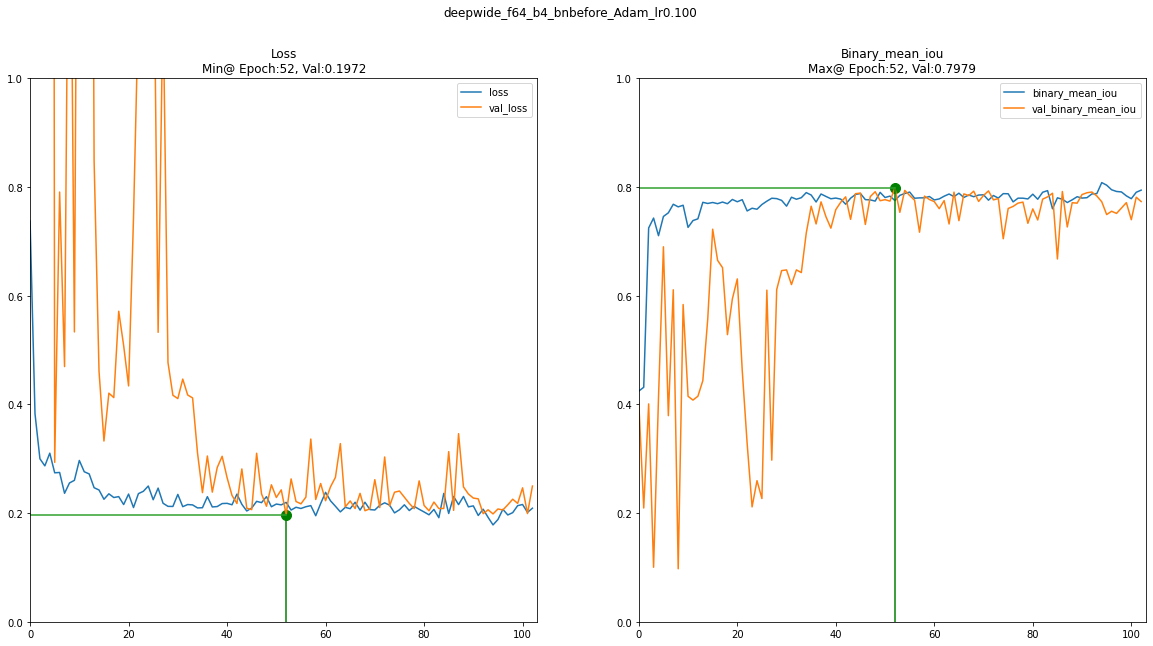

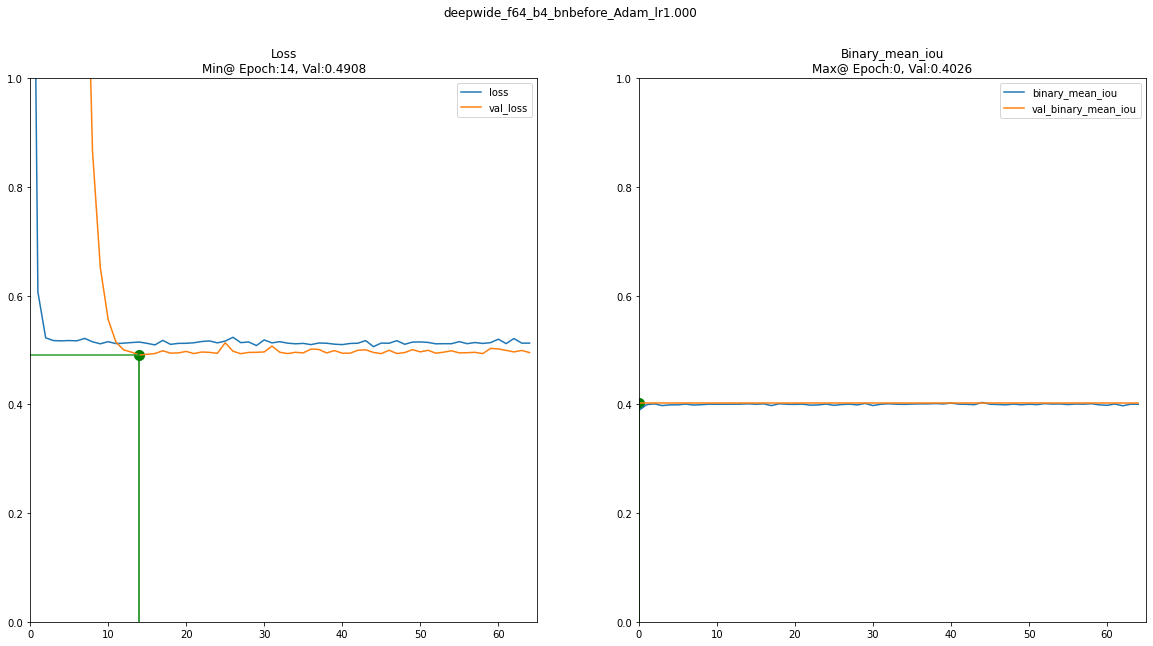

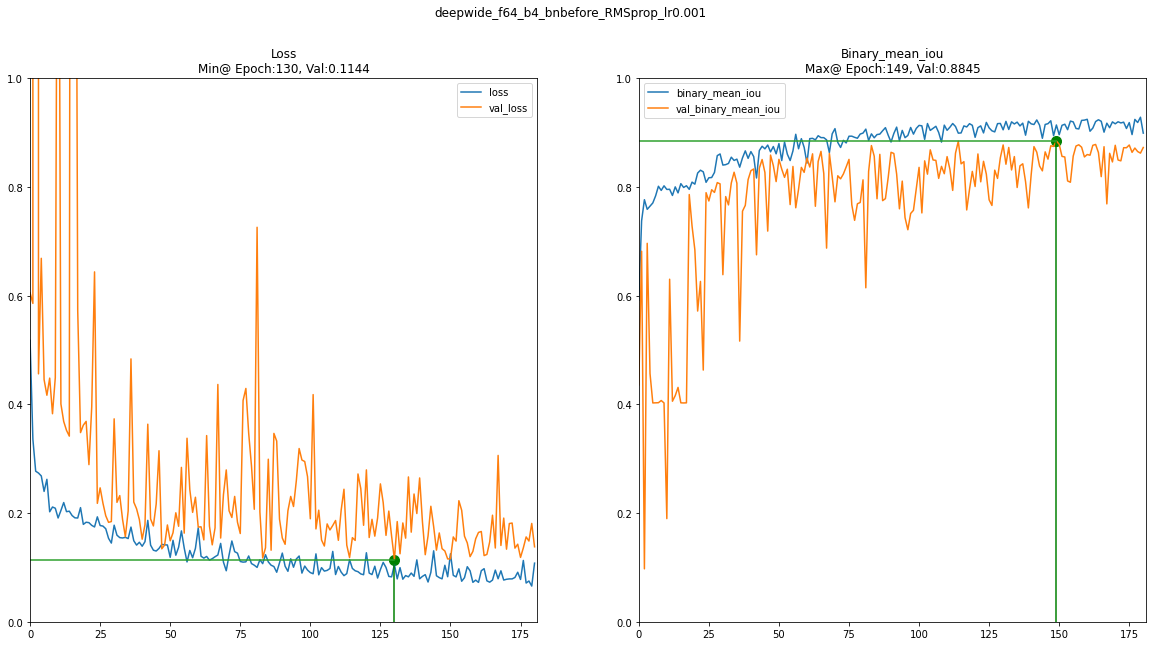

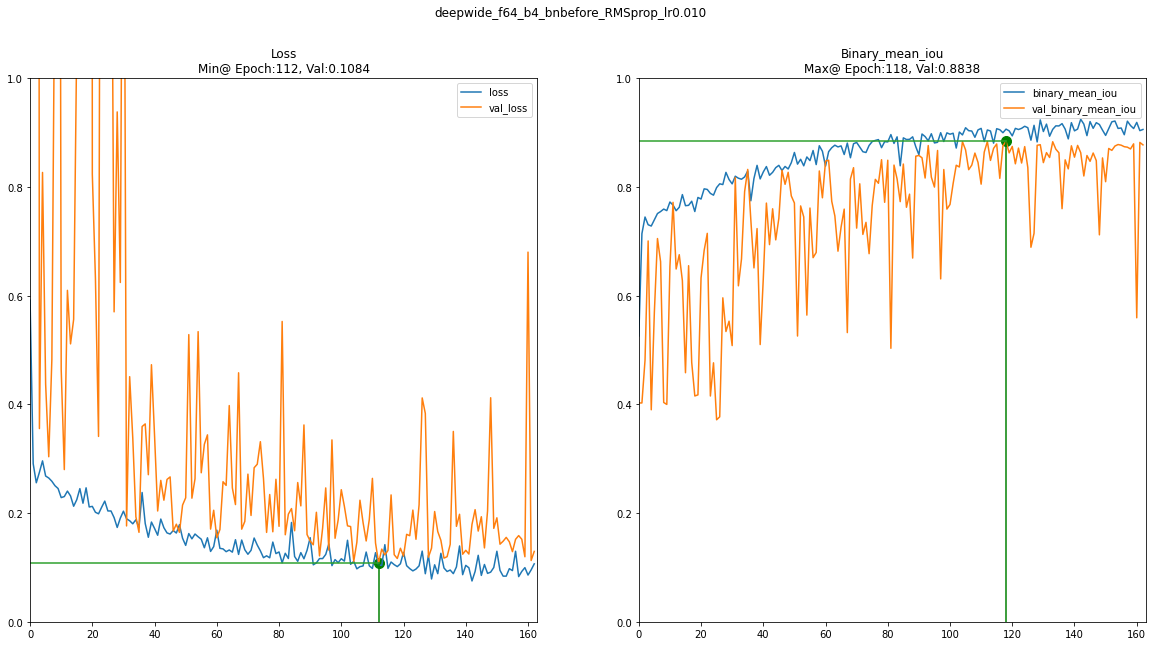

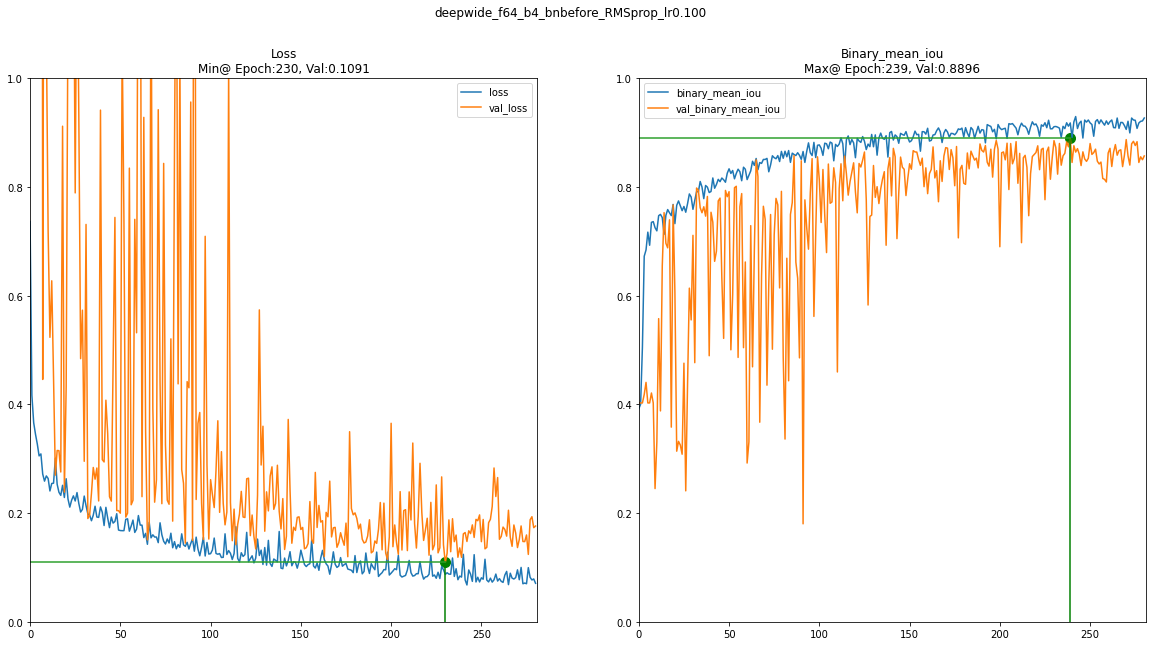

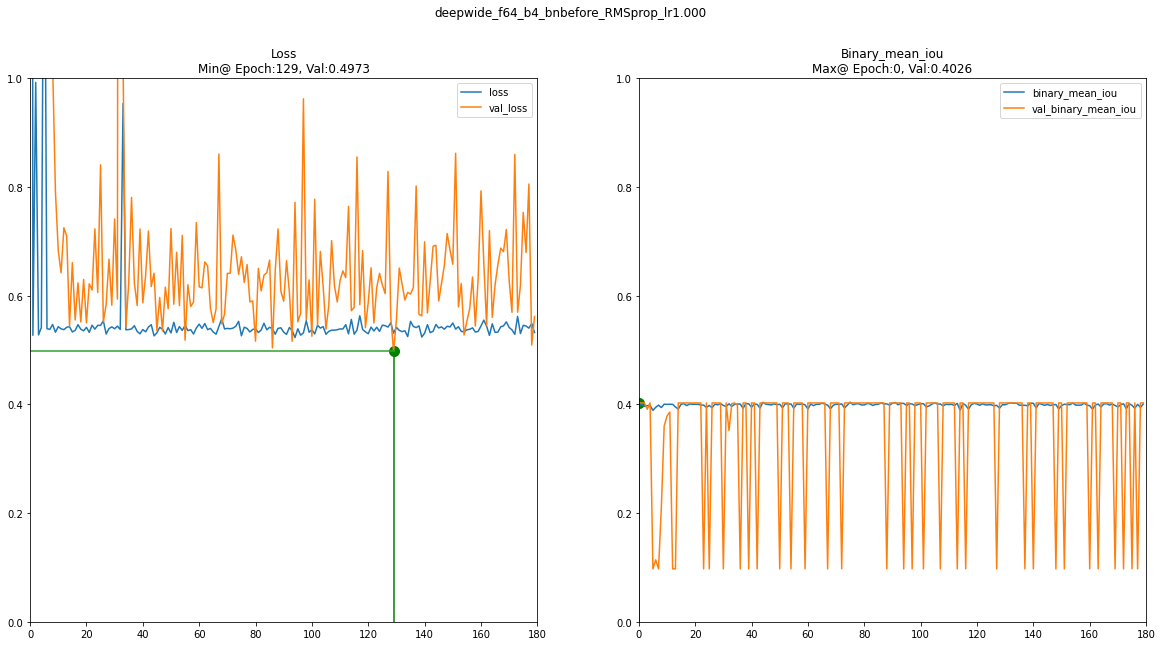

In [29]:
# Plot learning curves and create summary DataFrame
optimiser_df = pd.DataFrame(columns=['File', 'Val Loss', 'Val IoU', 'Best Epoch'])

for fn in sorted(histories):
    with open(fn, 'rb') as f:
        hist = pickle.load(f)
        
    hist_df = pd.DataFrame(hist)
    title = os.path.basename(fn).strip('history.pickle')
    vs.plot_model_history(hist_df, metrics=['loss', 'binary_mean_iou'],
                          best=['min','max'], title=title);
    
        
    best_epoch = hist_df.val_loss.argmin()
    optimiser_df = optimiser_df.append([{'File': title,
                                         'Val Loss': hist_df.val_loss.min(),
                                         'Val IoU': hist_df.val_binary_mean_iou.at[best_epoch],
                                         'Best Epoch': best_epoch}],
                                       ignore_index=True)

In [30]:
optimiser_df

,File,Val Loss,Val IoU,Best Epoch
0,deepwide_f64_b4_bnbefore_Adam_lr0.001,0.113332,0.876262,89
1,deepwide_f64_b4_bnbefore_Adam_lr0.010,0.113754,0.879744,112
2,deepwide_f64_b4_bnbefore_Adam_lr0.100,0.197231,0.797861,52
3,deepwide_f64_b4_bnbefore_Adam_lr1.000,0.490760,0.402579,14
4,deepwide_f64_b4_bnbefore_RMSprop_lr0.001,0.114391,0.877241,130
5,deepwide_f64_b4_bnbefore_RMSprop_lr0.010,0.108392,0.883421,112
6,deepwide_f64_b4_bnbefore_RMSprop_lr0.100,0.109106,0.885107,230
7,deepwide_f64_b4_bnbefore_RMSprop_lr1.000,0.497299,0.402579,129


In both cases a learning rate of 1 is too high! At 0.001 (the default learning rate for both optimisers) both Adam and RMSProp show similar performance. In general the RMSProp approach manages to achieve better `val_loss` values but runs for many more epochs than Adam.

Note here that the batch size also has an influence on the training process. I'll address the batch size later but generally smaller batch sizes add noise to the process and when used with a large learning rate the learning curves can become very volitile.

### Learning Rate Scheduler
Finally, it is worth trying the standard stochastic gradient descent optimiser too. Unlinke RMSPRop and Adam this is not adaptive but can be configured to modify the learning rate as training progresses. This effectively helps the optimiser to make fast progress at the start of training to a good set of weights before fine tuning them using smaller learning rates.

To implement this I will use a `LearningRateScheduler`. The first argument, `schedule`, should be a function that accepts `epoch` and `lr` arguments and returns the new learning rate. Note that this increases the number of hyperparamaters, for example schedule frequency and step factor i.e. how often to modify the learning rate and by how much.

In [18]:
# Step approach i.e. reduce learning rate by constant factor
# after every x steps.
def step_schedule(step_factor, freq):
    """Creates a step learning rate schedule
    
    After every `freq` epochs the current learning
    rate is reduced according to the `step_factor`
    """
    def schedule(epoch, lr):
        if epoch> 0 and epoch % freq == 0:
            return lr * step_factor
        else:
            return lr
    return schedule

In [19]:
# Eponential approach i.e. contually reduce learning rate
# exponentially
def exp_schedule(exp_factor, patience=0):
    """Creates a exponential decay learning rate schedule
    
    After `patience` epochs the current learning rate
    continually reduced according to the `exp_factor`
    """
    def schedule(epoch, lr):
        if epoch < patience:
            return lr
        else:
            return lr * exp_factor
    return schedule

In [20]:
def plot_lr_schedule(schedule, init_lr=0.01, epochs=100, figsize=(8,8), title=None):
    """Visualise schedule over epochs
    """
    epochs = np.arange(epochs)
    current_lr = init_lr
    lrs = []
    
    for e in epochs:
        new_lr = schedule(e,current_lr)
        lrs.append(new_lr)
        current_lr = new_lr
    
    plt.figure(figsize=figsize)
    plt.plot(epochs, lrs)
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.title(title)

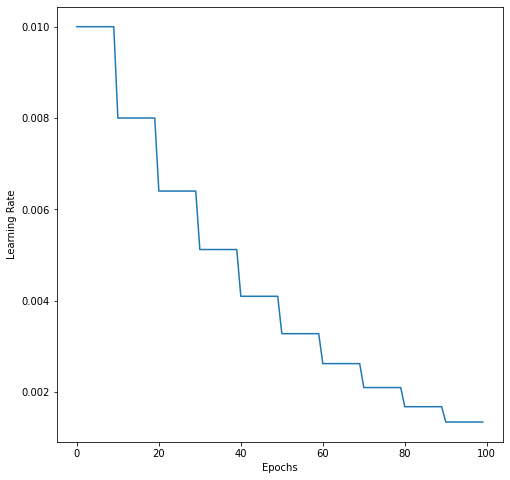

In [21]:
plot_lr_schedule(step_schedule(0.8, 10), epochs=100)

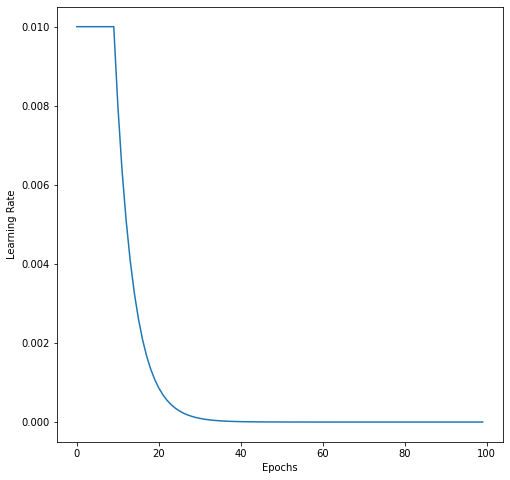

In [22]:
plot_lr_schedule(exp_schedule(0.8, 10), epochs=100)

In [23]:
# Learning Rate Schedule callbacks
from tensorflow.keras.callbacks import LearningRateScheduler

lrs_step = LearningRateScheduler(step_schedule(0.8, 10))
lrs_exp = LearningRateScheduler(exp_schedule(0.8, 10))

Finally, another approach is to monitor the val_loss and reduce the learning rate when it no longer improves. Keras provides a built-in callback for this purpose; `ReduceLearningRateOnPlateau`.

In [24]:
# Reduce on plateau
from tensorflow.keras.callbacks import ReduceLROnPlateau

# This scheduler will reduce the learnung rate by a factor
# of 0.8 if there is no improvement to `val_loss` (default)
# for 20 epochs. When lr is reduced the scheduler will
# wait for 10 epochs before continuing.
rlrp = ReduceLROnPlateau(factor=0.8,
                         patience=10,
                         cooldown=10)

In [ ]:
# Train models
optimisers = ['SGD']
lr_schedulers = [('LRSStep', lrs_step),
                 ('LRSExp', lrs_exp),
                 ('RLRP', rlrp)]
histories = []

for opt, (sch_name, sch_callback) in product(optimisers, lr_schedulers):
    # Create model
    model = UNet_BN(n_filters=64, n_blocks=4, bn_pos='before', model_name='deepwide')
    
    # Generate output base filename including optimiser and learning rate
    opt_obj = tf.optimizers.get(opt) # create instance of SGD to get default LR
    lr = opt_obj.get_config()['learning_rate']
    base_fn = f"{model.name}_{opt}_lr{lr:.3f}_{sch_name}"
    
    ## Configure callbacks
    # Checkpointer
    checkpointer = tf.keras.callbacks.ModelCheckpoint(f'model_outputs/{base_fn}.weights.h5',
                                                      save_best_only=True,
                                                      save_weights_only=True
                                                      )
    
    # Early stopping
    early_stop = EarlyStopping(patience=50)
    
    # Train model
    history = train_unet(model, nwpu_data_dir, nwpu_mask_dir, epochs=500,
                         optimiser=opt, learning_rate=lr
                         callbacks=[early_stop, checkpointer],
                         save_as=base_fn,
                         save_dir='model_outputs')
    
    histories.append(history)

In [63]:
# Or use pre-trained model
out_dir = 'model_outputs'
ptn = r'deepwide_f64_b4_bnbefore_SGD_lr\d\.\d{3}_(LRSStep|LRSExp|RLRP)\.history.pickle'
histories = [os.path.join(out_dir, fn) for fn in 
             list(filter(lambda x: re.match(ptn,x),os.listdir(out_dir)))]

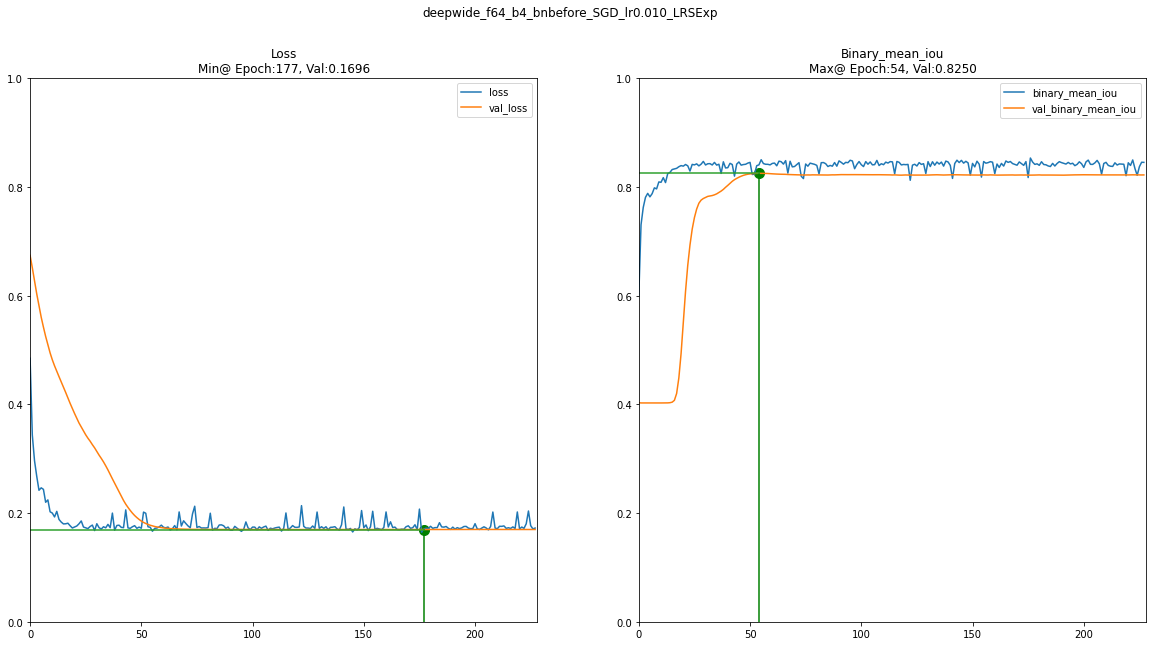

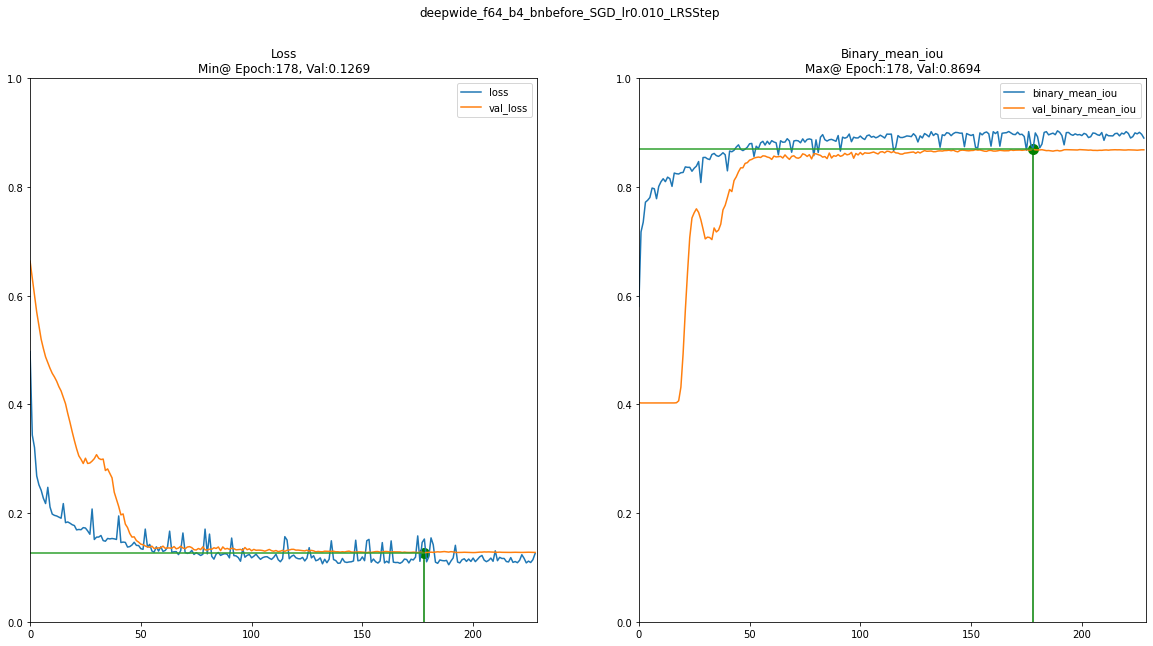

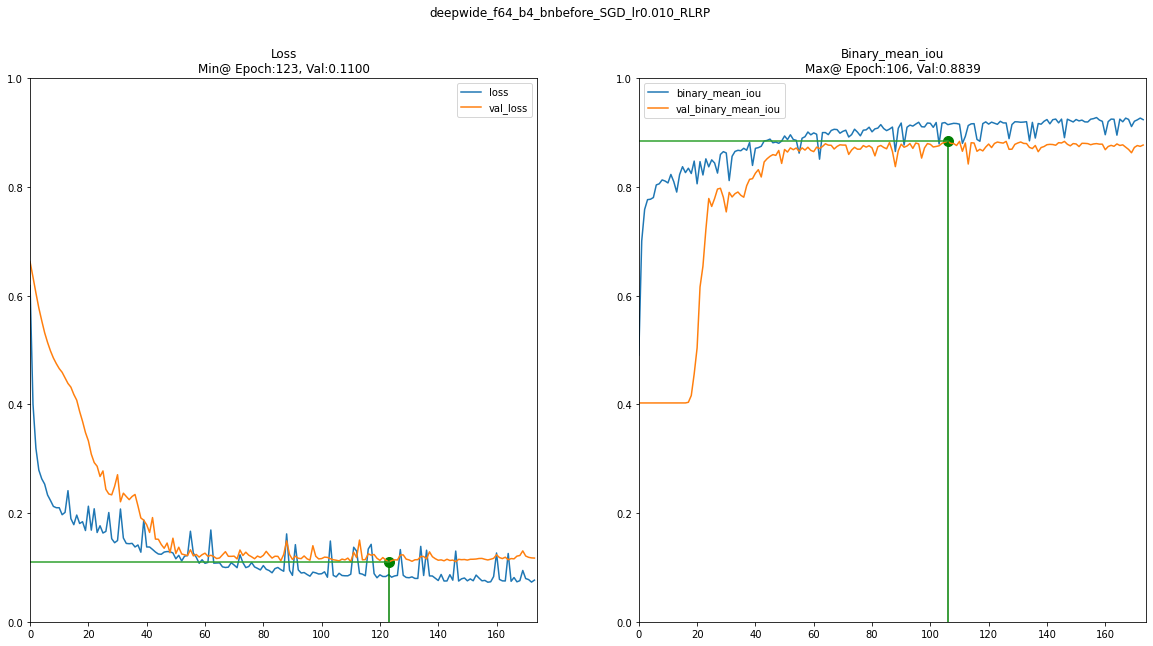

In [65]:
# Plot learning curves and create summary DataFrame
scheduler_df = pd.DataFrame(columns=['File', 'Val Loss', 'Val IoU', 'Best Epoch'])

for fn in sorted(histories):
    with open(fn, 'rb') as f:
        hist = pickle.load(f)
        
    hist_df = pd.DataFrame(hist)
    title = os.path.basename(fn).split('.history.pickle')[0]
    vs.plot_model_history(hist_df, metrics=['loss', 'binary_mean_iou'],
                          best=['min','max'], title=title);
    
        
    best_epoch = hist_df.val_loss.argmin()
    scheduler_df = scheduler_df.append([{'File': title,
                                         'Val Loss': hist_df.val_loss.min(),
                                         'Val IoU': hist_df.val_binary_mean_iou.at[best_epoch],
                                         'Best Epoch': best_epoch}],
                                       ignore_index=True)

In [66]:
scheduler_df

,File,Val Loss,Val IoU,Best Epoch
0,deepwide_f64_b4_bnbefore_SGD_lr0.010_LRSExp,0.169616,0.821636,177
1,deepwide_f64_b4_bnbefore_SGD_lr0.010_LRSStep,0.126895,0.869377,178
2,deepwide_f64_b4_bnbefore_SGD_lr0.010_RLRP,0.109958,0.882546,123


The best results here are acheived with the `ReduceLearningRateOnPlateau` method. This makes sense as one would presume that allowing the learning rate to be adjusted based on the learning feedback, as opposed to a predetermined schedule, would lead to better results.

Of course, this also depends on the initial learning rate as well as the choices for RLRP patience etc. This approach does create many more hyperparameters to tune, though they tend to have sensible default values.

## Batch Size

The `batch_size` hyperparameter is another important one that influences the dynamics of the learning algorithm i.e. optimiser. It impacts how quickly a model learns and the stability of the learning process.

Batch size controls the accuracy of the estimate of the error gradient; the larger batch size, the more accurate this estimate of the gradent will be. This means that it is more likely for subsequent gradient descent steps to result in better weights and therefore loss.

However, larger batch sizes require more memory and can take more epochs to converge. In the extreme case of batch gradient descent, where a single batch of all training samples is used, the weights are only adjusted once per epoch. With a smaller batch size, the weights are updated multiple times through an epoch, i.e. after each batch. While these updates may be noisier, the model can learn in fewer epochs due to the greater amout of feedback. That said, it may not reach as optimum a result as with larger batch sizes because of this noise. Therefore, there is an important trade off.

Of course, the learning rate also plays a key role. Generally, more noisy updates to the model (small batch size) require a smaller learning rate, whereas less noisy, more accurate updates can utilise larger learning rates. Essentially, the more confident you are in your direction, the bigger the step you can take.

Small batches generally lead to faster learning but a volatile learning process. Larger batch sizes slow down the learning process but the final stages result in a convergence to a more stable model.

Here I will look at the effect of batch size on the best model configurations so far:

- RMSProp with lr = 0.01
- RMSProp with lr = 0.1
- SGD with lr = 0.01 and ReduceLearningRateOnPlateau

Note that due to compute limitations the maximum batch size I can test is 32 which may be sub-optimal.

In [ ]:
lr = [0.01, 0.1] # best LRs from optimiser/lr comparison
batch_sizes = [8, 16, 32]

# Create dataframe to store results
summary_df3 = pd.DataFrame(columns=['File', 'Runtime', 'Best Epoch',
                                    'Val Loss', 'Val IoU'])

for lr, bs in product(lr, batch_sizes):
    model = UNet_BN(n_filters=64, n_blocks=4, bn_pos='before', model_name='deepwide')
    compile_model(model, 'RMSProp', lr=lr)
    
    
    # Generate filename for output files
    opt_conf = model.optimizer.get_config()
    o_name = opt_conf['name']
    o_lr = f"{tf.keras.backend.eval(opt_conf['learning_rate']):.3f}"
    base_fn = os.path.join(out_dir, f"{model.name}_{o_name}_lr{o_lr}_bs{bs}{{}}")
    
    ## Configure callbacks
    # Checkpointer
    checkpointer = tf.keras.callbacks.ModelCheckpoint(base_fn.format('.weights.h5'),
                                                      save_best_only=True,
                                                      save_weights_only=True
                                                      )
    # Timer
    timer = TrainingTimer()
    
    # Early stopping
    early_stop = EarlyStopping(patience=50)
    
    
    callbacks=[early_stop, checkpointer, timer]

    
    # Train model
    history = train_unet(model, nwpu_data_dir, nwpu_mask_dir,
                         callbacks=callbacks, epochs=500,
                         batch_size=bs)
    
    # Add results to summary
    best_epoch = early_stop.stopped_epoch - early_stop.patience
    iou_at_epoch = history.history['val_binary_mean_iou'][best_epoch]
    summary_df3 = summary_df3.append([{'File': base_fn.format(''),
                                       'Runtime': timer.runtime_minutes(),
                                       'Best Epoch': best_epoch,
                                       'Val Loss': checkpointer.best,
                                       'Val IoU': iou_at_epoch}],
                                    ignore_index=True)
    
    # Save history to pickle
    with open(base_fn.format('.history.pickle'), 'wb') as f:
        pickle.dump(history.history, f)

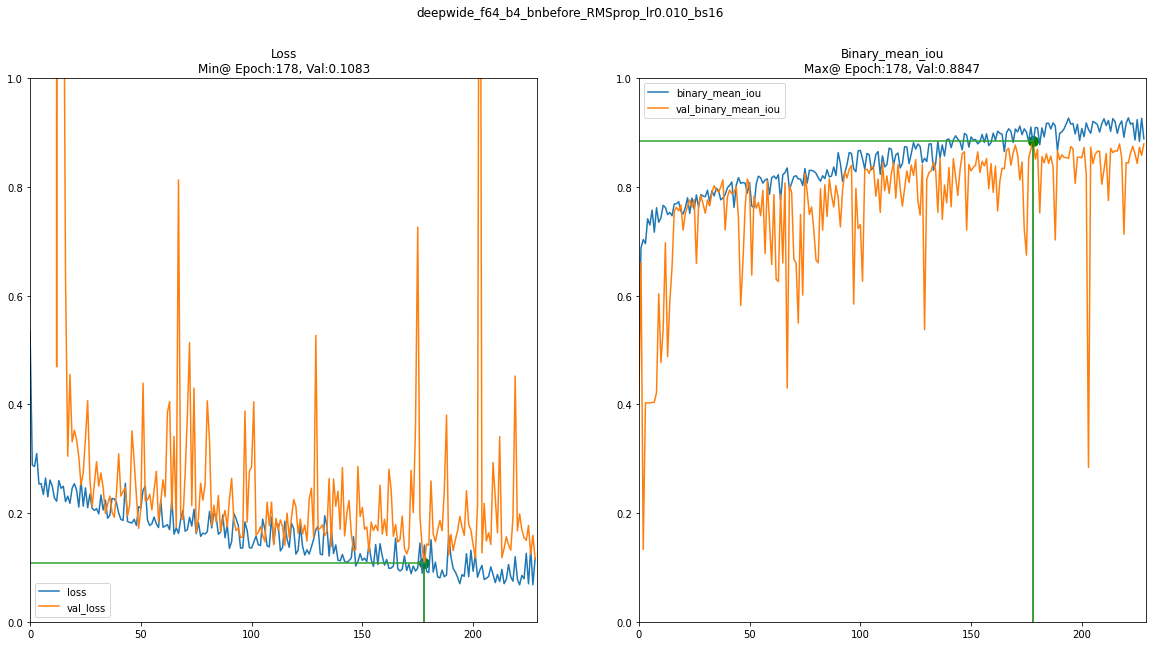

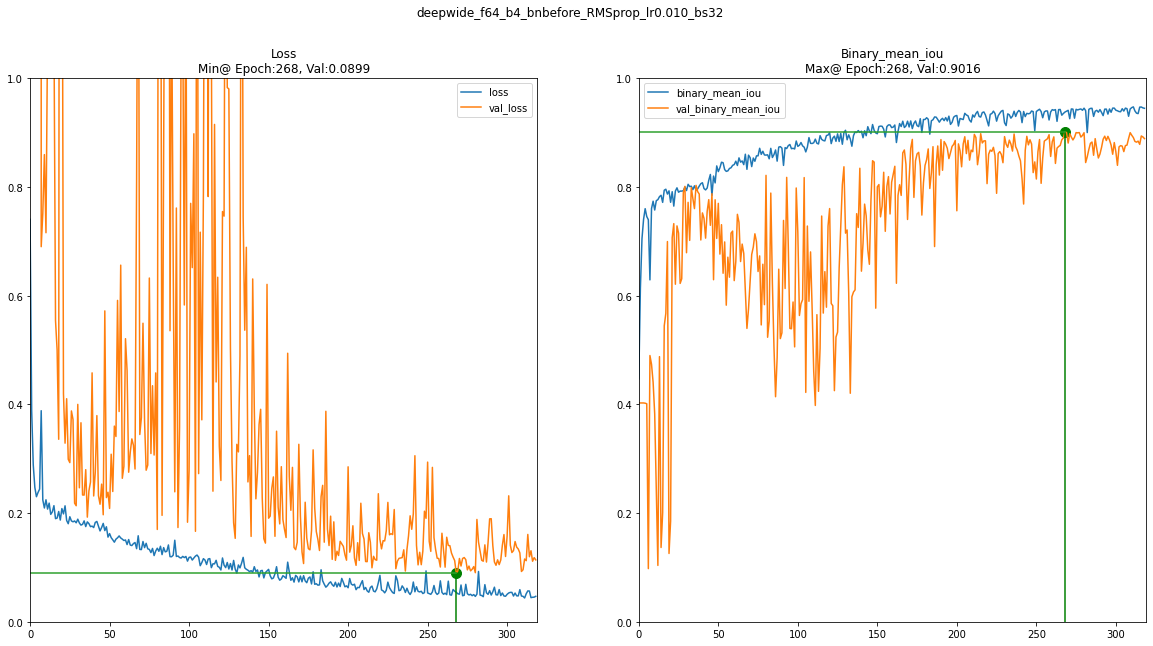

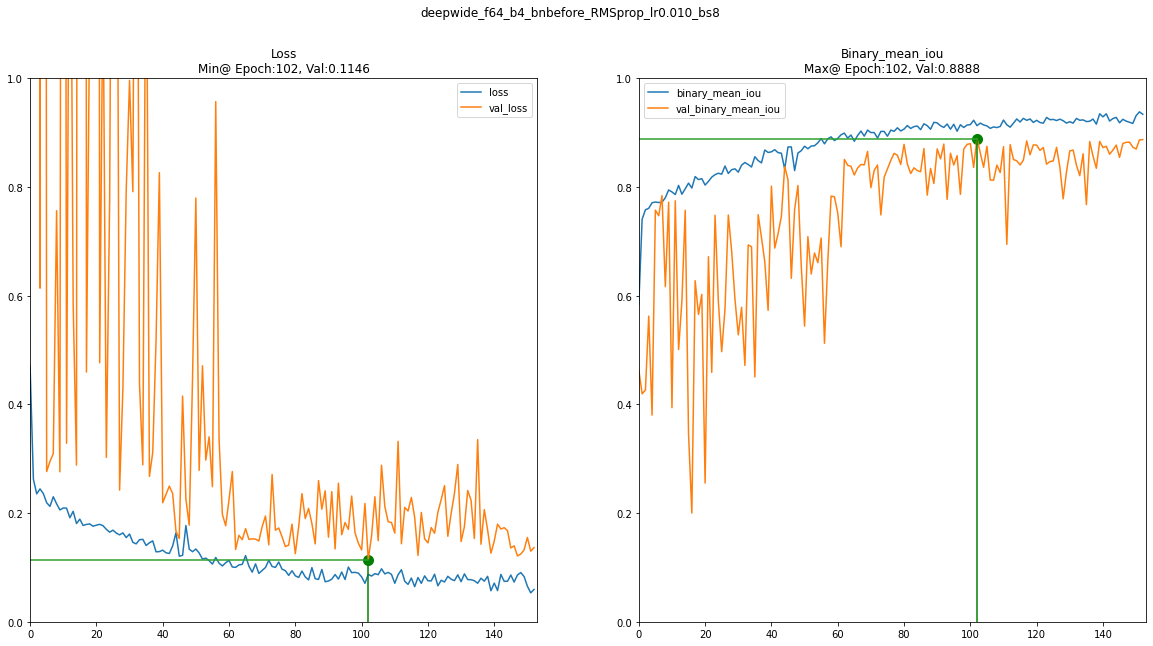

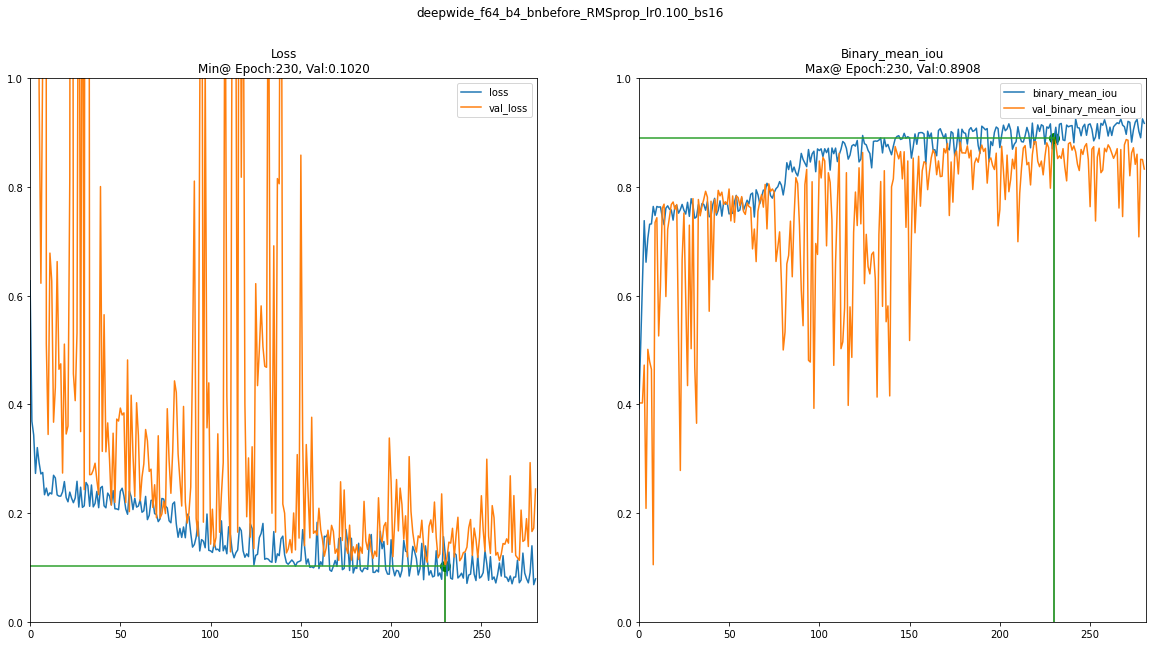

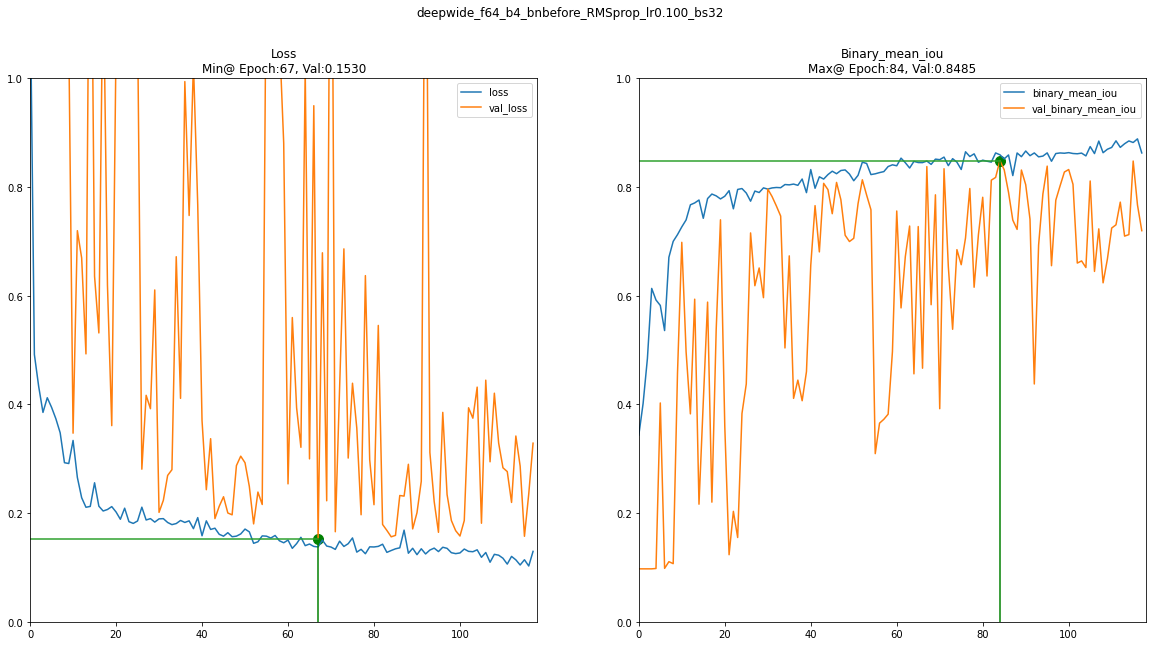

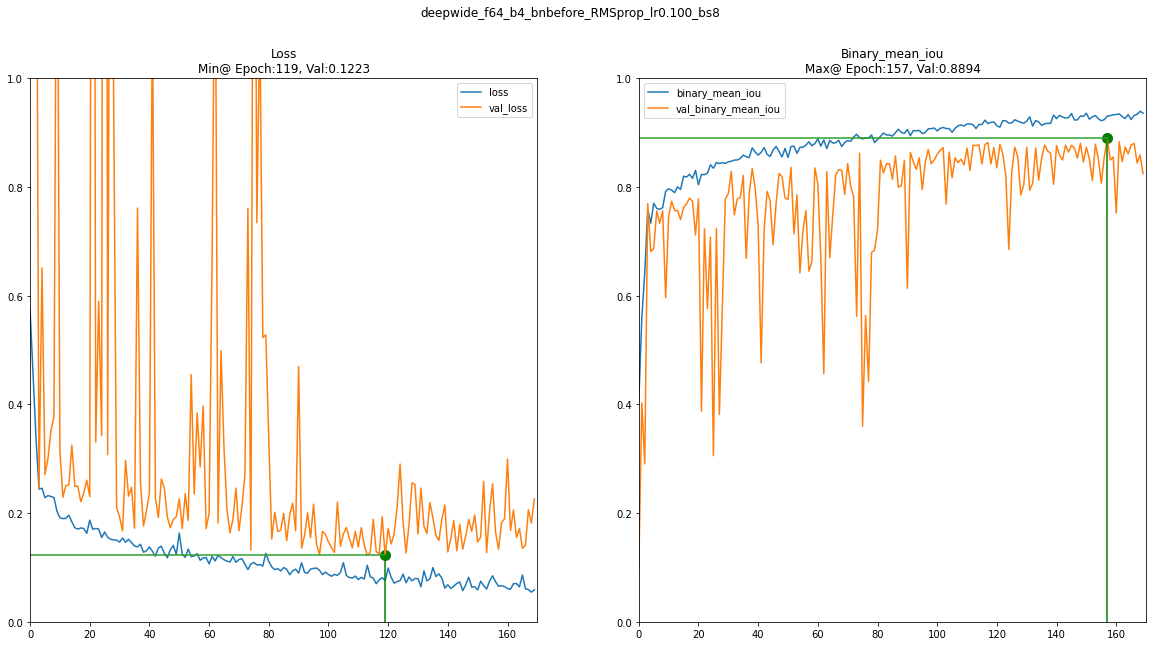

In [41]:
# Load results if not trained in this session
ptn = r'deepwide_f64_b4_bnbefore_RMSprop_lr\d\.\d{3}_bs\d{1,2}\.history.pickle'
histories = sorted(list(filter(lambda x: re.match(ptn,x),os.listdir(out_dir))))

# Create dataframe to store results
summary_df3 = pd.DataFrame(columns=['File', 'Best Epoch', 'Val Loss', 'Val IoU'])

for fn in sorted(histories):
    with open(os.path.join(out_dir,fn), 'rb') as pf:
        hist_dict = pickle.load(pf)
        
    hist_df = pd.DataFrame(hist_dict)
    title = os.path.basename(fn).split('.history.pickle')[0]
    vs.plot_model_history(hist_df, metrics=['loss', 'binary_mean_iou'],
                          best=['min','max'], title=title);
        
    best_epoch = hist_df.val_loss.argmin()
    summary_df3 = summary_df3.append([{'File': title,
                                       'Best Epoch': best_epoch,
                                       'Val Loss': hist_df.val_loss.min(),
                                       'Val IoU': hist_df.val_binary_mean_iou.at[best_epoch]}],
                                    ignore_index=True)

In [42]:
summary_df3

,File,Best Epoch,Val Loss,Val IoU
0,deepwide_f64_b4_bnbefore_RMSprop_lr0.010_bs16,178,0.108330,0.884654
1,deepwide_f64_b4_bnbefore_RMSprop_lr0.010_bs32,268,0.089929,0.901558
2,deepwide_f64_b4_bnbefore_RMSprop_lr0.010_bs8,102,0.114560,0.888810
3,deepwide_f64_b4_bnbefore_RMSprop_lr0.100_bs16,230,0.102002,0.890818
4,deepwide_f64_b4_bnbefore_RMSprop_lr0.100_bs32,67,0.152983,0.837422
5,deepwide_f64_b4_bnbefore_RMSprop_lr0.100_bs8,119,0.122327,0.872303


With the learning rate set to `0.01` all experiments show a noisey learning process suggesting that a larger batch size could be used. The model trained using a batch size of `8` reaches convergence in fewer epochs than the others. As expected, with a batch size of `32` many more epochs are required for convervence. It can be seen that the later stages of training are more stable (less volitile) and a better solution is found.

With a learning rate of `0.1`, again the learning process is very noisey. The largest batch size of `32` actually reaches a solution the quickest but it is the worst solution of all experiments. The model does not look like it is converging so could suggest that for this batch size the learning rate is set too high. The models trained using batch sizes of `8` and `16` are unstable throughout and look like they are starting to overfit the data.

In [ ]:
# Test SGD with RLRP and default learning rate (best result from schedulers comparison)
batch_sizes = [8, 16, 32]

# Create dataframe to store results
summary_df4 = pd.DataFrame(columns=['File', 'Runtime', 'Best Epoch',
                                    'Val Loss', 'Val IoU'])

for bs in batch_sizes:
    model = UNet_BN(n_filters=64, n_blocks=4, bn_pos='before', model_name='deepwide')
    compile_model(model, 'SGD')
    
    
    # Generate filename for output files
    opt_conf = model.optimizer.get_config()
    o_name = opt_conf['name']
    o_lr = f"{tf.keras.backend.eval(opt_conf['learning_rate']):.3f}"
    base_fn = os.path.join(out_dir, f"{model.name}_{o_name}_lr{o_lr}_bs{bs}{{}}")
    
    ## Configure callbacks
    # Checkpointer
    checkpointer = tf.keras.callbacks.ModelCheckpoint(base_fn.format('.weights.h5'),
                                                      save_best_only=True,
                                                      save_weights_only=True
                                                      )
    # Timer
    timer = TrainingTimer()
    
    # Early stopping
    early_stop = EarlyStopping(patience=50)
    
    # Reduce LR on Plateau
    rlrp = ReduceLROnPlateau(factor=0.8,
                         patience=10,
                         cooldown=10)
    
    
    callbacks=[early_stop, checkpointer, timer, rlrp]

    
    # Train model
    history = train_unet(model, nwpu_data_dir, nwpu_mask_dir,
                         callbacks=callbacks, epochs=500,
                         batch_size=bs)
    
    # Add results to summary
    best_epoch = early_stop.stopped_epoch - early_stop.patience
    iou_at_epoch = history.history['val_binary_mean_iou'][best_epoch]
    summary_df4 = summary_df4.append([{'File': base_fn.format(''),
                                       'Runtime': timer.runtime_minutes(),
                                       'Best Epoch': best_epoch,
                                       'Val Loss': checkpointer.best,
                                       'Val IoU': iou_at_epoch}],
                                    ignore_index=True)
    
    # Save history to pickle
    with open(base_fn.format('.history.pickle'), 'wb') as f:
        pickle.dump(history.history, f)

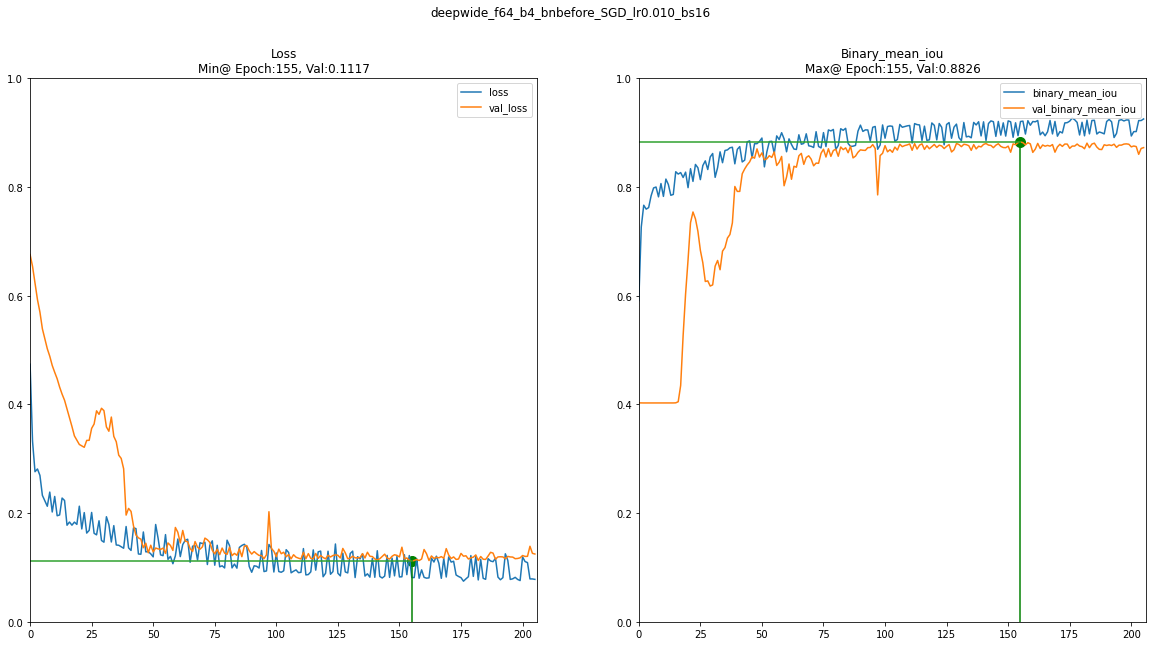

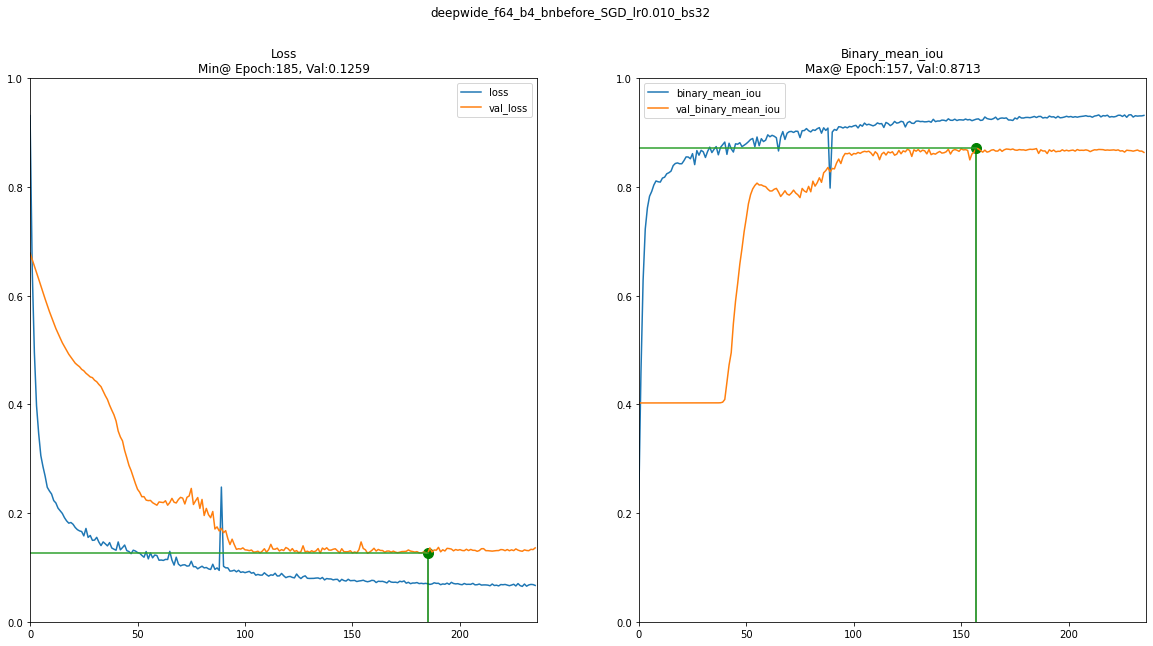

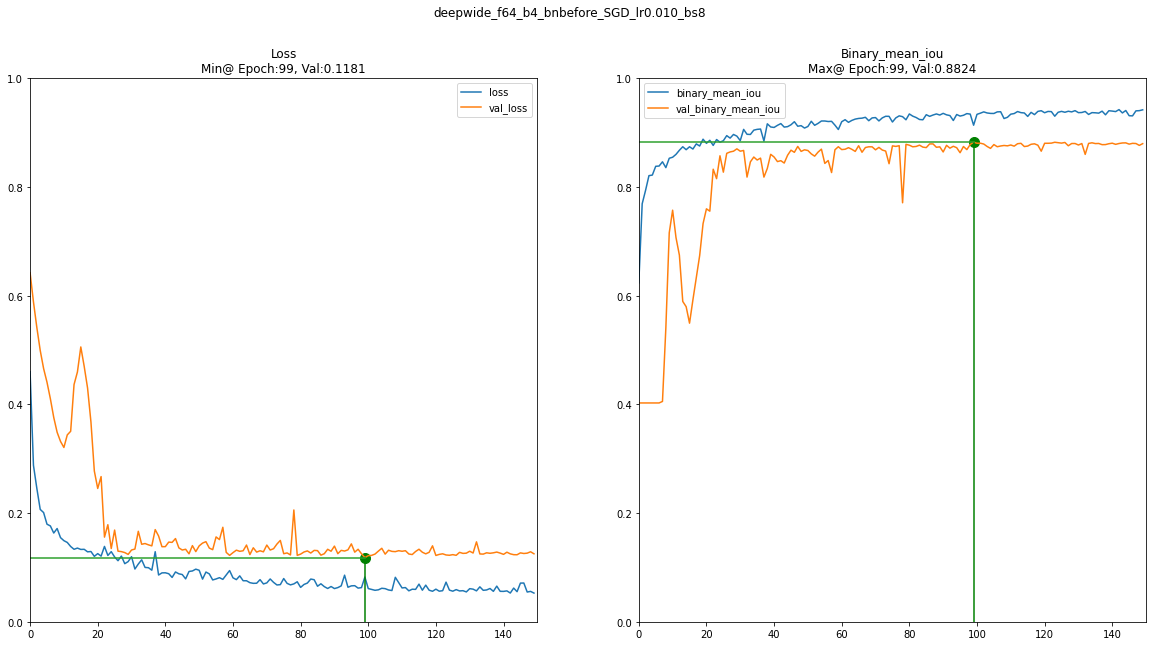

In [46]:
# Load results if not trained in this session
ptn = r'deepwide_f64_b4_bnbefore_SGD_lr\d\.\d{3}_bs\d{1,2}\.history.pickle'
histories = sorted(list(filter(lambda x: re.match(ptn,x),os.listdir(out_dir))))

# Create dataframe to store results
summary_df4 = pd.DataFrame(columns=['File', 'Best Epoch', 'Val Loss', 'Val IoU'])

for fn in sorted(histories):
    with open(os.path.join(out_dir,fn), 'rb') as pf:
        hist_dict = pickle.load(pf)
        
    hist_df = pd.DataFrame(hist_dict)
    title = os.path.basename(fn).split('.history.pickle')[0]
    vs.plot_model_history(hist_df, metrics=['loss', 'binary_mean_iou'],
                          best=['min','max'], title=title);
        
    best_epoch = hist_df.val_loss.argmin()
    summary_df4 = summary_df4.append([{'File': title,
                                       'Best Epoch': best_epoch,
                                       'Val Loss': hist_df.val_loss.min(),
                                       'Val IoU': hist_df.val_binary_mean_iou.at[best_epoch]}],
                                    ignore_index=True)

In [47]:
summary_df4

,File,Best Epoch,Val Loss,Val IoU
0,deepwide_f64_b4_bnbefore_SGD_lr0.010_bs16,155,0.111675,0.882620
1,deepwide_f64_b4_bnbefore_SGD_lr0.010_bs32,185,0.125932,0.870519
2,deepwide_f64_b4_bnbefore_SGD_lr0.010_bs8,99,0.118138,0.882391


As the batch size increases the models require more epochs to find a solution. The learning curves look very similar but, interestingly, the worst performing model is with a batch size of `32` - though it is the most stable. The results from batch size `8` and `16` only differ very slightly but with `16` coming out on top.

## Model Selection

At this point I will choose a model to perform final testing on. The table below summarises all experiments in this notebook.

In [51]:
results = pd.concat([summary_df1,
                     summary_df2,
                     summary_df3,
                     summary_df4],
                    ignore_index=True)

results

,File,Best Epoch,Val Loss,Val IoU
0,deepwide_f64_b4_bnbefore_Adam_lr0.001,89,0.113332,0.876262
1,deepwide_f64_b4_bnbefore_Adam_lr0.010,112,0.113754,0.879744
2,deepwide_f64_b4_bnbefore_Adam_lr0.100,52,0.197231,0.797861
3,deepwide_f64_b4_bnbefore_Adam_lr1.000,14,0.490760,0.402579
4,deepwide_f64_b4_bnbefore_RMSprop_lr0.001,130,0.114391,0.877241
5,deepwide_f64_b4_bnbefore_RMSprop_lr0.010,112,0.108392,0.883421
6,deepwide_f64_b4_bnbefore_RMSprop_lr0.100,230,0.109106,0.885107
7,deepwide_f64_b4_bnbefore_RMSprop_lr1.000,129,0.497299,0.402579
8,deepwide_f64_b4_bnbefore_SGD_lr0.010_LRSExp,177,0.169616,0.821636
9,deepwide_f64_b4_bnbefore_SGD_lr0.010_LRSStep,178,0.126895,0.869377


In [55]:
# Best by `val_loss`
results.iloc[[results['Val Loss'].argmin()]]

,File,Best Epoch,Val Loss,Val IoU
12,deepwide_f64_b4_bnbefore_RMSprop_lr0.010_bs32,268,0.089929,0.901558


Over these experiments the model showing the best `val_loss` (and `val_binary_mean_iou`) is **deepwide_f64_b4_bnbefore_RMSprop_lr0.01_bs32**:

- 64 filters
- 4 encode blocks
- 4 deode blocks
- RMSProp with learning rate 0.01
- Batch size of 32
- Trained using early stopping.


Val Loss = **0.0899**; Val IoU = **0.9012**

Let's see how this model performs on the test data in the final evaluation!